In [69]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [70]:
stock_data = pd.read_csv('tsla_2025.csv')

In [71]:
stock_data = stock_data[['Date', 'Close']]

In [72]:
stock_data['Date'] = pd.to_datetime(stock_data['Date'], format="%Y-%m-%d")


In [73]:
stock_data.set_index(['Date'], inplace=True)

In [74]:
stock_data

,Close
Date,
2010-06-28,1.13333
2010-06-29,1.59267
2010-06-30,1.58867
2010-07-01,1.46400
2010-07-02,1.28000
...,...
2025-01-13,403.31000
2025-01-14,396.36000
2025-01-15,428.22000


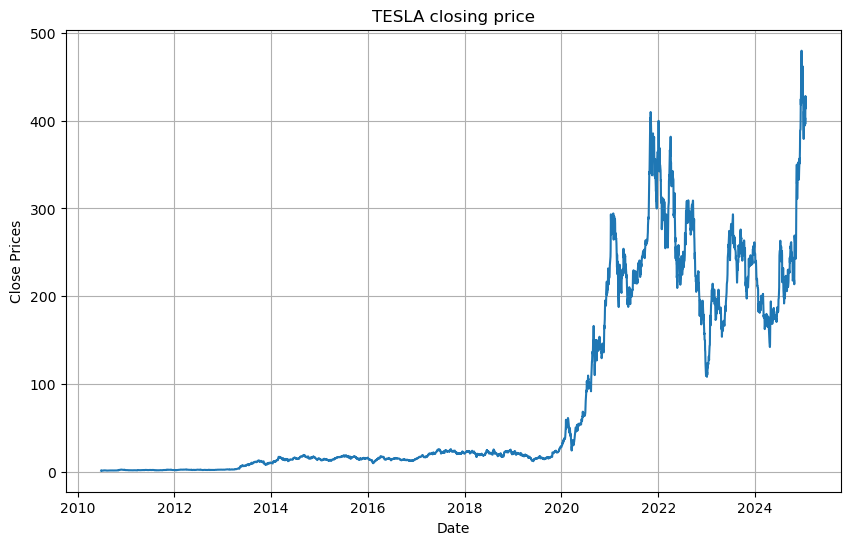

In [75]:

plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['Close'])
plt.title('TESLA closing price')
plt.show()

<Axes: ylabel='Density'>

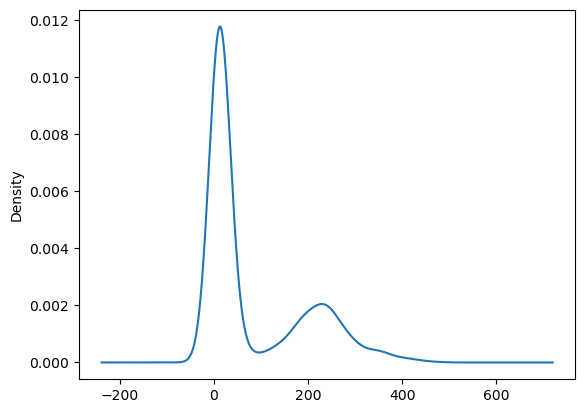

In [76]:
stock_data['Close'].plot(kind='kde')

In [77]:
from statsmodels.tsa.stattools import adfuller


test_result = adfuller(stock_data['Close'])


test_result


def adfuller_test(stock_data):
    result = adfuller(stock_data)
    labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
    for value, label in zip(result, labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")


adfuller_test(stock_data['Close'])

ADF Test Statistic : 0.07956265383710145
p-value : 0.9646377207173463
#Lags Used : 28
Number of Observations Used : 3634
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [78]:
from statsmodels.tsa.stattools import kpss

def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

    if (kpss_output['p-value'] < 0.05):
        print("The time series is not stationary")
    else:
        print("The time series is stationary")


kpss_test(stock_data['Close'])


Results of KPSS Test:
Test Statistic            6.752421
p-value                   0.010000
Lags Used                38.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
The time series is not stationary


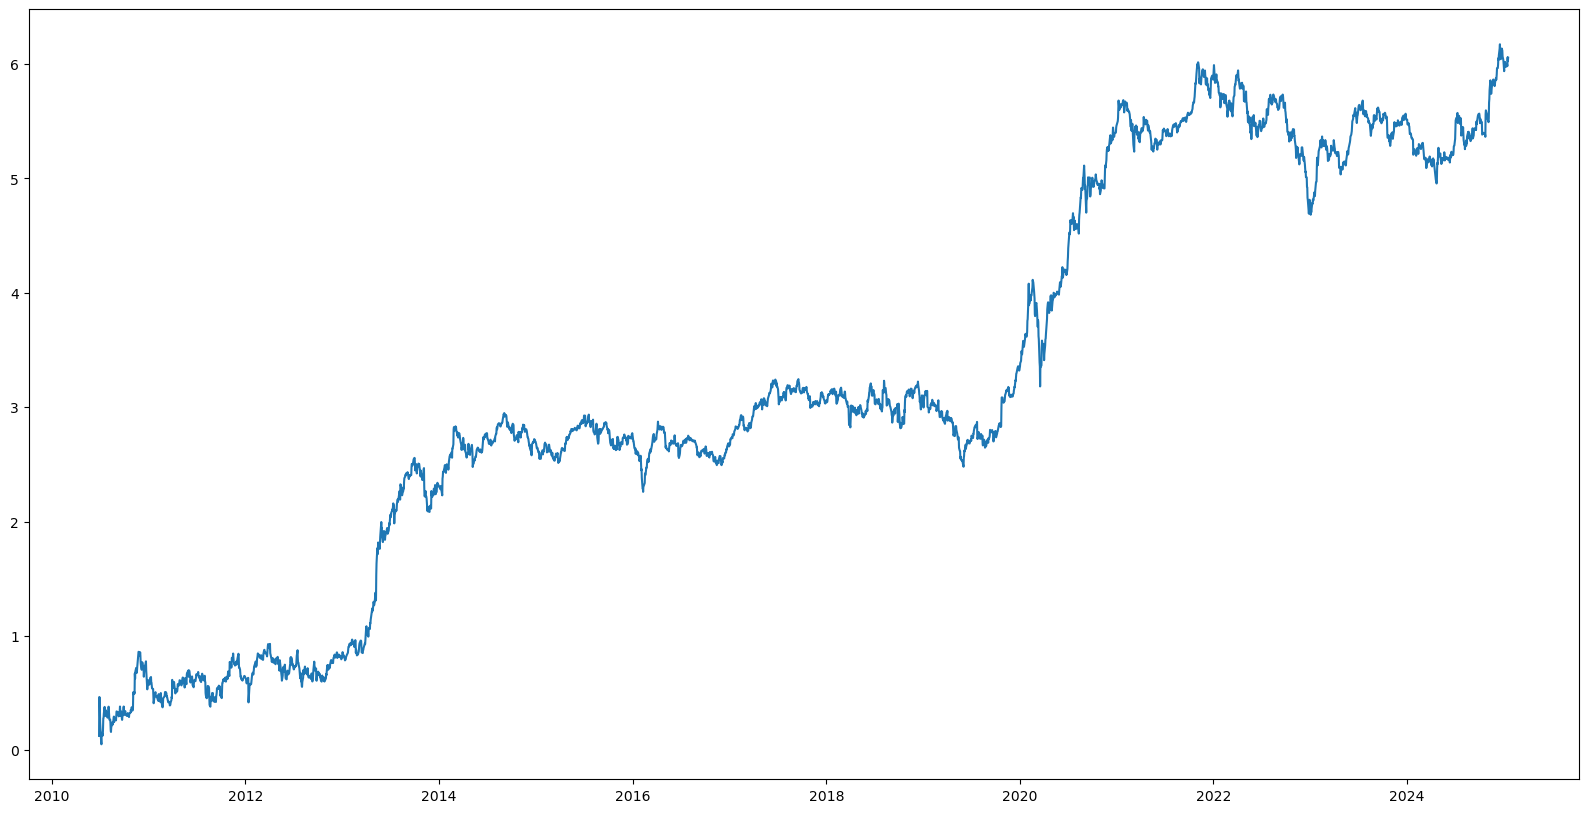

In [79]:
# LOG TRANSFORMATION FOR **STATIONARY**

plt.figure(figsize=(20,10))
stock_data_log = np.log(stock_data)
plt.plot(stock_data_log)

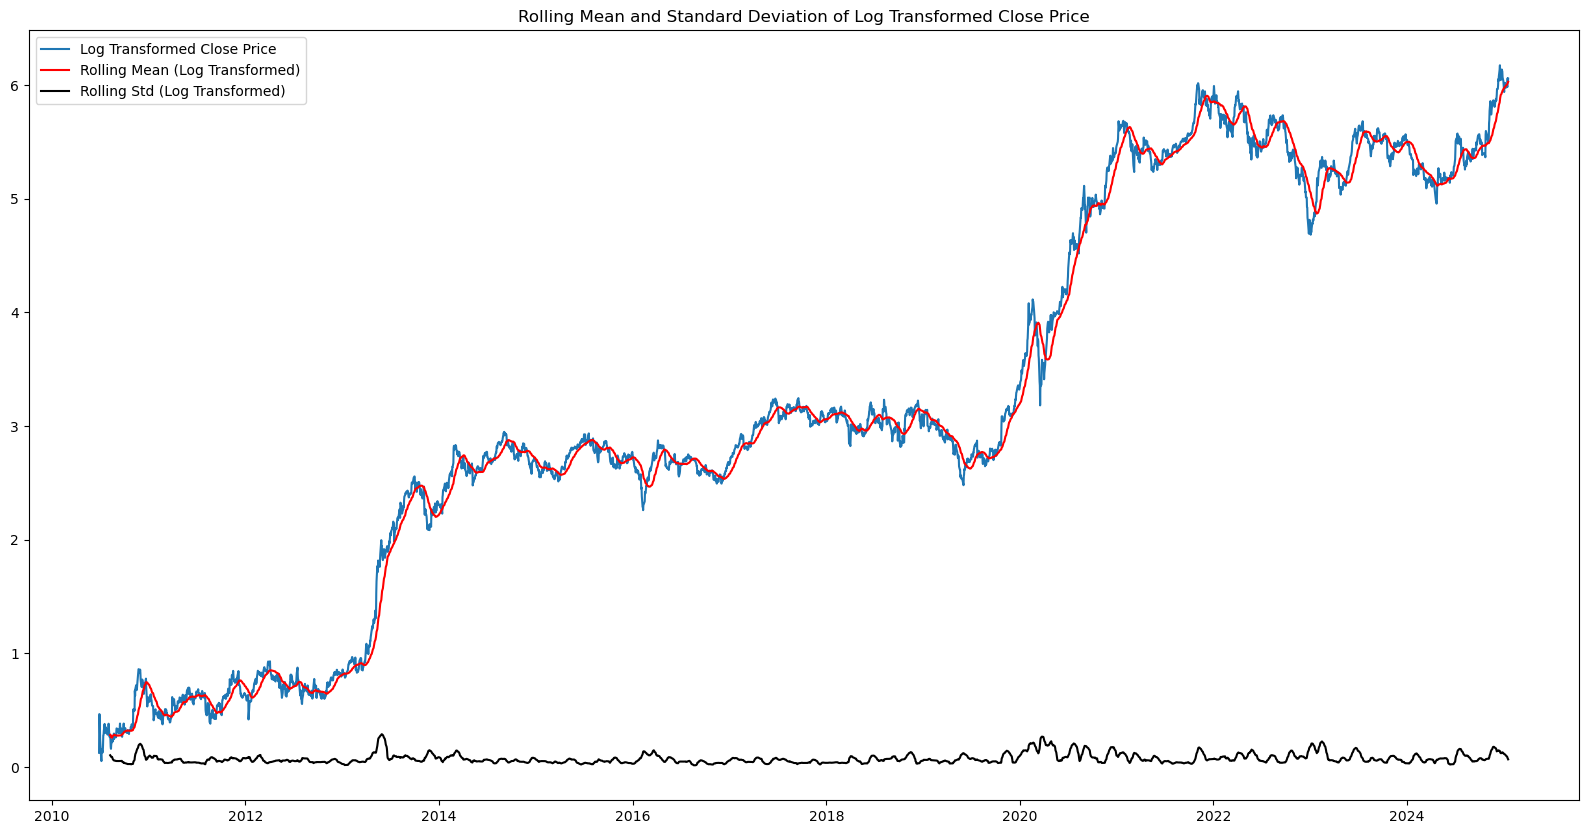

In [80]:
plt.figure(figsize=(20,10))
MAvg = stock_data_log.rolling(window=30).mean()
MStd = stock_data_log.rolling(window=30).std()
plt.plot(stock_data_log, label='Log Transformed Close Price')
plt.plot(MAvg, color='red', label='Rolling Mean (Log Transformed)')
plt.plot(MStd, color='black', label='Rolling Std (Log Transformed)')
plt.title('Rolling Mean and Standard Deviation of Log Transformed Close Price')
plt.legend()
plt.show()

In [81]:
adfuller_test(stock_data_log['Close'])

ADF Test Statistic : -0.8337778873410399
p-value : 0.8089981966004898
#Lags Used : 0
Number of Observations Used : 3662
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [82]:
kpss_test(stock_data_log['Close'])

Results of KPSS Test:
Test Statistic            8.574946
p-value                   0.010000
Lags Used                38.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
The time series is not stationary


In [83]:
stock_data_log.head()

,Close
Date,
2010-06-28,0.125160
2010-06-29,0.465412
2010-06-30,0.462897
2010-07-01,0.381172
2010-07-02,0.246860


In [84]:
stock_data_log.shift().head()

,Close
Date,
2010-06-28,NaN
2010-06-29,0.125160
2010-06-30,0.465412
2010-07-01,0.462897
2010-07-02,0.381172


In [85]:
stock_data_shift = stock_data_log-stock_data_log.shift()

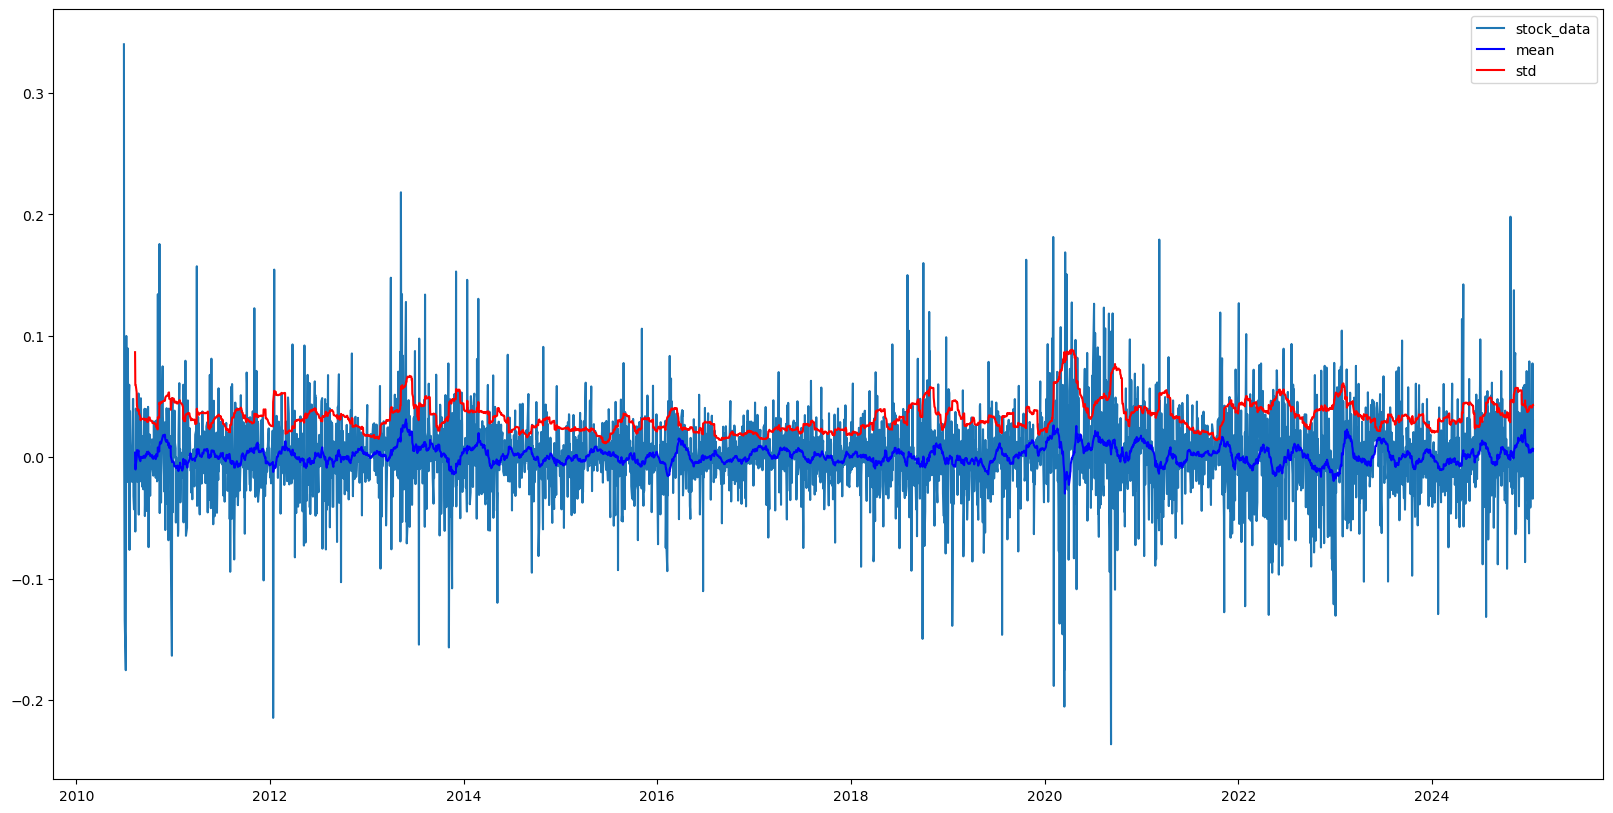

In [86]:
plt.figure(figsize=(20,10))
MAvg=stock_data_shift.rolling(window=30).mean()
MStd=stock_data_shift.rolling(window=30).std()
plt.plot(stock_data_shift, label='stock_data')
plt.plot(MAvg, color='blue', label='mean')
plt.plot(MStd, color='red', label='std')
plt.legend()

In [87]:
adfuller_test(stock_data_shift['Close'].dropna())

ADF Test Statistic : -61.33065277263732
p-value : 0.0
#Lags Used : 0
Number of Observations Used : 3661
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [88]:
kpss_test(stock_data_shift['Close'].dropna())

Results of KPSS Test:
Test Statistic           0.066547
p-value                  0.100000
Lags Used                7.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64
The time series is stationary


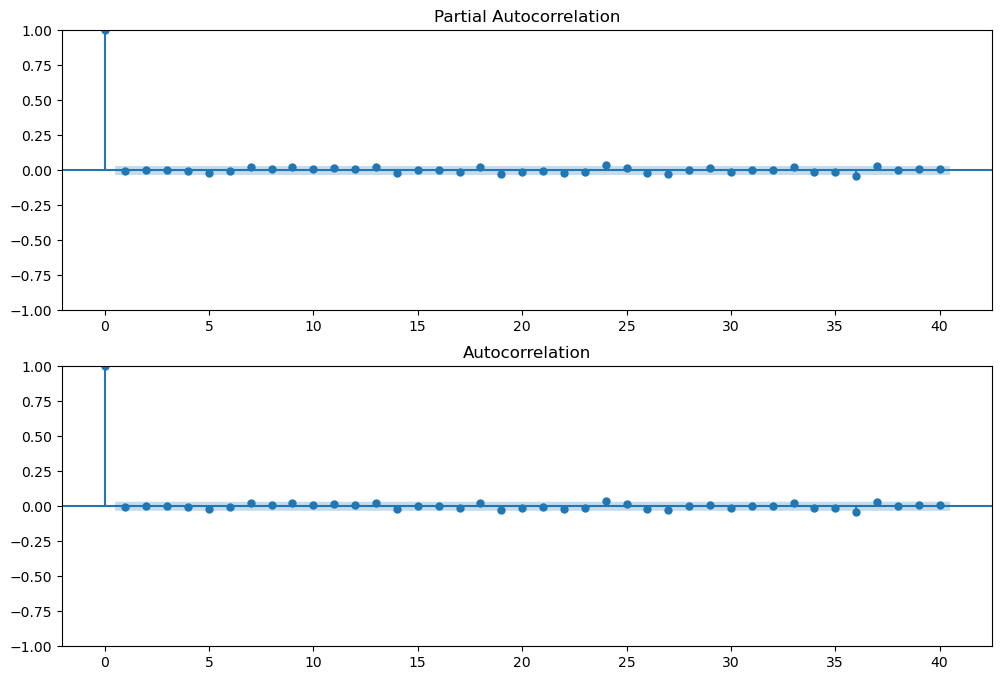

In [89]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# %%
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_pacf(stock_data_shift['Close'].dropna(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_acf(stock_data_shift['Close'].dropna(), lags=40, ax=ax2)

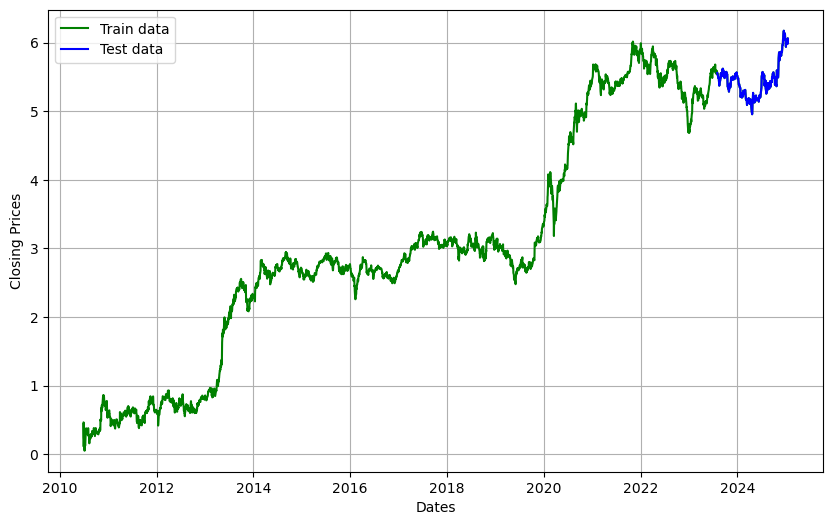

In [90]:
train_data, test_data = stock_data_log[3:int(len(stock_data_log)*0.9)], stock_data_log[int(len(stock_data_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(stock_data_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [91]:
forecast_log = model_fit.predict(start=len(train_data),
                                 end=len(stock_data_log)-1,
                                 dynamic=True)
forecast = np.exp(forecast_log)
stock_data['forecast'] = pd.Series(forecast, index=test_data.index)

In [92]:
from statsmodels.tsa.arima.model import ARIMA

# Create the ARIMA model
model = ARIMA(stock_data_log['Close'], order=(0, 1, 0))  # adjust (p,d,q) for better results

# Fit the model
model_fit = model.fit()

# Print the summary
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3663
Model:                 ARIMA(0, 1, 0)   Log Likelihood                6928.634
Date:                Sat, 25 Oct 2025   AIC                         -13855.268
Time:                        00:58:51   BIC                         -13849.062
Sample:                             0   HQIC                        -13853.058
                               - 3663                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0013   1.51e-05     87.881      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              6313.78
Prob(Q):                              0.91   Pr

In [93]:
forecast_log = model_fit.predict(start=len(train_data),
                                 end=len(stock_data_log)-1,
                                 dynamic=True)
forecast = np.exp(forecast_log)
stock_data['forecast'] = pd.Series(forecast, index=test_data.index)

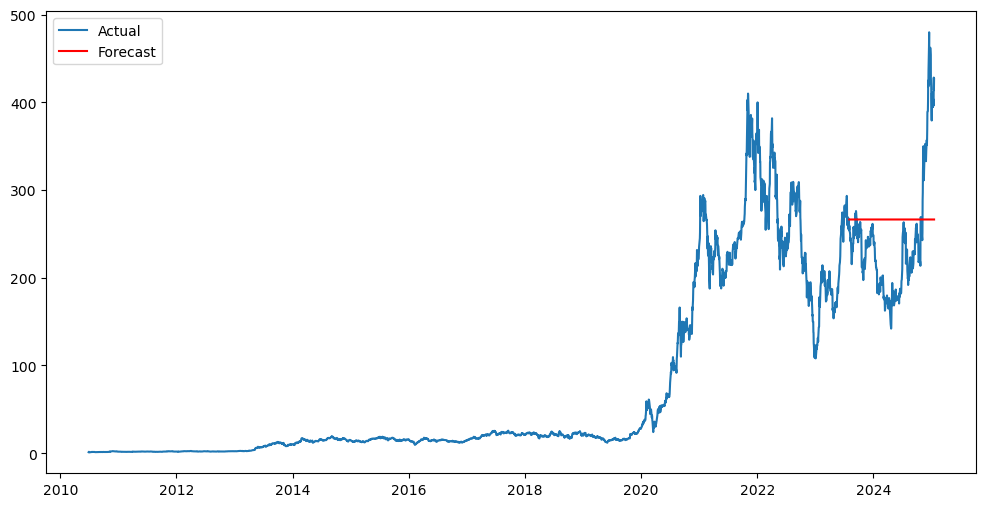

In [94]:

plt.figure(figsize=(12,6))
plt.plot(stock_data['Close'], label='Actual')
plt.plot(stock_data['forecast'], label='Forecast', color='red')
plt.legend()
plt.show()

In [95]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np


In [96]:
y_true = test_data['Close']
y_pred = stock_data['forecast'].loc[test_data.index]
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100



In [97]:
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}%")

MSE: 68118.84406325062
RMSE: 260.99586982029166
MAE: 260.995754119723
MAPE: 4803.609428540174%


In [98]:
from pmdarima import auto_arima



model_drift = auto_arima(
    train_data,
    d=1,                         
    seasonal=False,
    with_intercept=True,         
    suppress_warnings=True,
    stepwise=True
)


print(model_drift.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3293
Model:               SARIMAX(0, 1, 0)   Log Likelihood                6281.589
Date:                Sat, 25 Oct 2025   AIC                         -12559.177
Time:                        00:58:56   BIC                         -12546.979
Sample:                             0   HQIC                        -12554.810
                               - 3293                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0016      0.001      2.503      0.012       0.000       0.003
sigma2         0.0013   1.71e-05     75.457      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   0.10   Jarque-

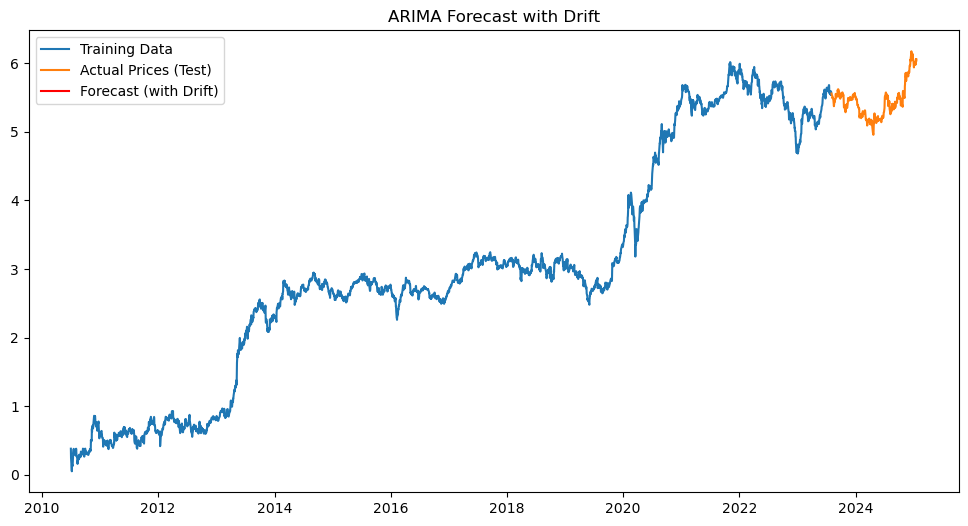

In [99]:

n_periods_to_forecast = len(test_data)
forecast_drift = model_drift.predict(n_periods=n_periods_to_forecast)


forecast_series = pd.Series(forecast_drift, index=test_data.index)


plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Actual Prices (Test)')
plt.plot(forecast_series, color='red', label='Forecast (with Drift)') # <--- Should now be sloped
plt.title('ARIMA Forecast with Drift')
plt.legend()
plt.show()

In [100]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np


y_true = test_data['Close']

y_pred = stock_data['forecast'].loc[test_data.index]


mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [101]:
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Mean Squared Error (MSE): 68118.84406325062
Root Mean Squared Error (RMSE): 260.99586982029166
Mean Absolute Error (MAE): 260.995754119723
Mean Absolute Percentage Error (MAPE): 4803.61%
